In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,MaxPooling2D,Conv2D,Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [2]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'sugarcane',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    # validation_split=0.2,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    # data_format=None,
    verbose=True,
)

Found 744 files belonging to 3 classes.


In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_data)

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#shuffle the data to get good acc

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [7]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
from keras.applications import ResNet50
conv_base = ResNet50(
           weights = 'imagenet',
           include_top = False,
           input_shape = (128,128,3)
)

out = conv_base.output
out  = GlobalAveragePooling2D()(out)
out = Flatten()(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.5)(out)
out = Dense(256, activation='relu')(out)
ut = Dropout(0.2)(out)
out = Dense(128, activation='relu')(out)
predictions = Dense(3, activation='softmax')(out)
model = Model(inputs=conv_base.input, outputs=predictions)

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [27]:
history = model.fit(
    x=train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.3987 - loss: 1.2021 - val_accuracy: 0.4250 - val_loss: 1.0383
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7152 - loss: 0.6894 - val_accuracy: 0.5500 - val_loss: 0.8812
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8671 - loss: 0.3990 - val_accuracy: 0.5750 - val_loss: 1.3621
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9253 - loss: 0.2520 - val_accuracy: 0.7000 - val_loss: 0.9822
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9433 - loss: 0.1530 - val_accuracy: 0.8000 - val_loss: 0.5050
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9638 - loss: 0.1014 - val_accuracy: 0.9000 - val_loss: 0.2254
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9844 - loss: 0.0733 - val_accuracy: 0.9250 - val_loss: 0.1251
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9820 - loss: 0.0529 - val_accuracy: 0.9750 - val_loss

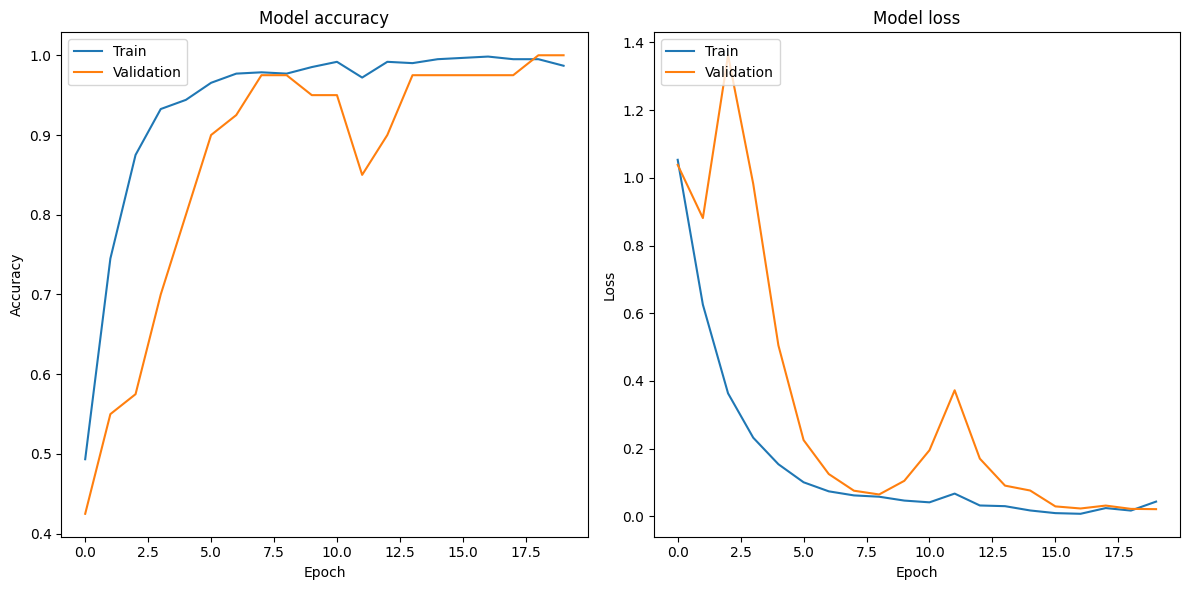

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0080


[0.007318894844502211, 1.0]

In [30]:
model.save("sugarcane_model.keras")

In [31]:
import json
with open("sugarcane_hist01.json","w") as f:
    json.dump(history.history , f)

In [16]:
class_names = train_data.class_names
class_names

['Sugarcane_Bacterial Blight', 'Sugarcane_Healthy', 'Sugarcane_Red Rot']